In [54]:
import numpy as np
import torch
import torch.nn as nn
import os
from dataclasses import dataclass
from neural_verification import *
import matplotlib.pyplot as plt
import itertools
import copy

# This GeneralRNN has been defined in neural_verification, but I modified it:
# (1) comment out some assertions which throw out errors but aren't really errors?
# (2) Not only return hidden (last hidden states), but also hidden2 (second-to-last hidden states)
device = torch.device("cpu")
class ModifiedRNN(GeneralRNN):

    def forward_sequence(self, x):
        """This function takes in a sequence of inputs and returns a sequence of outputs
        as well as the final hidden state."""
        # x shape: (batch_size, sequence_length, input_dim)
        batch_size = x.size(0)
        seq_length = x.size(1)
        hidden = torch.zeros(batch_size, self.hidden_dim).to(self.device)
        assert x.size(2) == self.config.input_dim
        assert x.device == self.device
        outs = []
        hiddens=[]
        for i in range(seq_length):
            out, hidden = self.forward(x[:,i,:], hidden)
            outs.append(out)
            hiddens.append(hidden)
        # out shape: (batch_size, sequence_length, output_dim)
        return torch.stack(outs).permute(1,0,2), torch.stack(hiddens).permute(1,0,2) 

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

data = torch.load("../tasks/rnn_identity_numerical/data.pt")

config = torch.load("../tasks/rnn_identity_numerical/model_config.pt", map_location=torch.device('cpu'))
model = ModifiedRNN(config,device=device)
model.load_state_dict(torch.load("../tasks/rnn_identity_numerical/model_perfect.pt",map_location=torch.device('cpu')))

<All keys matched successfully>

In [70]:
!pip install openpyxl

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement openpyxl (from versions: none)
ERROR: No matching distribution found for openpyxl


In [55]:
outs = model.forward_sequence(data[0].unsqueeze(dim=2))[0].cpu().detach().numpy()
hiddens = model.forward_sequence(data[0].unsqueeze(dim=2))[1].cpu().detach().numpy()
thres = 1e-1

In [56]:
def linear(input, output, show_eqn=True):
    
    reg = LinearRegression().fit(input, output)
    score = reg.score(input, output)
    coeff = reg.coef_
    intercept = reg.intercept_

    if show_eqn:
        equation = "y = " + " + ".join([f"{coef}*x{idx}" for idx, coef in enumerate(coeff)]) + f" + {intercept}"
        print(f"Linear Equation:{equation}")
    return score, coeff, intercept 

def polynomial_fit(input, output, degree=2, show_eqn=True):
    poly = PolynomialFeatures(degree=degree)
    input_poly = poly.fit_transform(input)

    reg = LinearRegression().fit(input_poly, output)
    score = reg.score(input_poly, output)

    if show_eqn:
        # Formatting coefficients with corresponding powers
        equation_terms = [f"{coef}*x^{i}" for i, coef in enumerate(reg.coef_)]
        equation = "y = " + " + ".join(equation_terms) + f" + {reg.intercept_}"
        print(f"Polynomial Equation (degree {degree}): {equation}")

    return score, reg.coef_, reg.intercept_

((900000, 10, 1), (900000, 10, 1))

Hidden to Output

In [61]:
from sklearn.linear_model import LinearRegression
reg = linear(hiddens.squeeze(2), outs.squeeze(2), show_eqn=False)

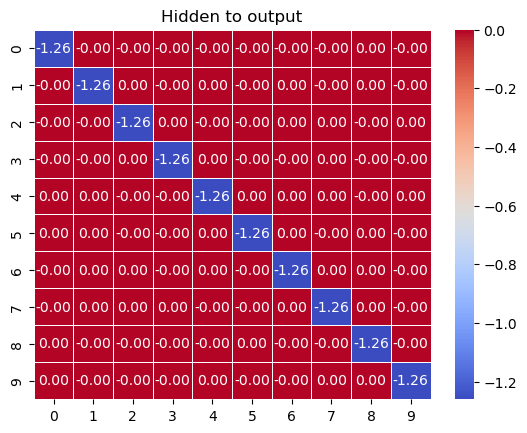

In [62]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Create a heatmap using seaborn
sns.heatmap(reg[1], annot=True, fmt=".2f", linewidths=.5, cmap="coolwarm")
plt.title("Hidden to output")
plt.show()

In [68]:
from sklearn.linear_model import LinearRegression
intercs=[]
for i in range(data[0].shape[1]-1):
    score,coef,inter = linear(np.concatenate([hiddens[:,-2-i],data[0]], axis=1), hiddens[:,-1-i], show_eqn=False)
    intercs.append(coef)
intercs = np.array(intercs).squeeze(1)

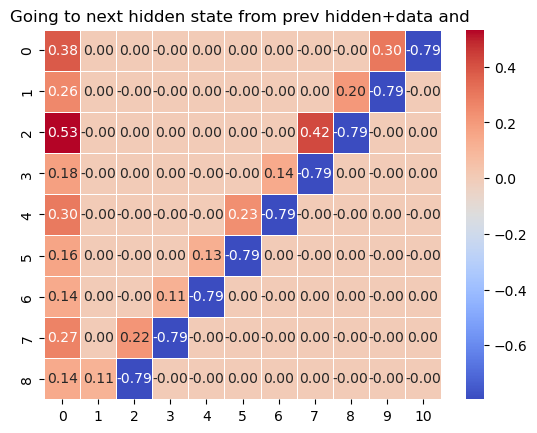

''

In [69]:
sns.heatmap(intercs, annot=True, fmt=".2f", linewidths=.5, cmap="coolwarm")
plt.title("Going to next hidden state from prev hidden+data and ")
plt.show()

""

In [36]:
for k,v in nfa.weights.items():
    print((k,v.shape))

('hmlp.mlp.0.weight', torch.Size([1, 2]))
('hmlp.mlp.0.bias', torch.Size([1]))
('ymlp.mlp.0.weight', torch.Size([1, 1]))
('ymlp.mlp.0.bias', torch.Size([1]))


In [ ]:
"""
('in2hidden.weight', torch.Size([2, 3]))
('hidden2hidden.weight', torch.Size([2, 2]))
('hidden2hidden.bias', torch.Size([2]))
('hidden2out.weight', torch.Size([3, 2]))
('hidden2out.bias', torch.Size([3]))
"""

In [34]:
from RNN_to_DFA_vedang import NFA
weights = model.state_dict()

nfa = NFA(10, weights)
points = list(np.concatenate([hidden[:10], hidden_last[:10]], axis=1))


nfa.accommodate_points(points, 0.8)
nfa.find_transitions()

points = np.stack(points, axis=1)

ValueError: zero-size array to reduction operation minimum which has no identity

In [23]:
def subset(arr, criterion=None, batch_size = 32):
    '''if arr contains too many samples, computation can be expensive.
    Choosing a subset of samples if usually enough for lattice detection.'''
    if criterion != None:
        arr = arr[np.where(criterion(arr))[0]]
    batch_id = np.random.choice(arr.shape[0], batch_size)
    arr = arr[batch_id]
    return arr  


# GCD

def get_vol_arr(x):
    '''Given n points in R^D, return all possible volumes of D+1 points'''
    num = x.shape[0]
    groups = np.array(list(itertools.combinations(x, D+1)))
    groups = groups[:,1:,:] - groups[:,[0],:]
    vols = np.abs(np.linalg.det(np.array(groups)))
    return np.array(vols)


def GCD_arr(arr):
    '''Find the greatest common divisor (GCD) for an array'''
    vol_arr = get_vol_arr(arr)
    while True:
        va = arr[[0]]; vb = arr[[1]]; v3 = arr[2:D+1]
        a = np.linalg.det(np.concatenate([va, v3], axis=0))
        b = np.linalg.det(np.concatenate([vb, v3], axis=0))
        
        # should be more robust? Threshold?
        if b == 0 or a == 0:
            if b == 0:
                arr = np.delete(arr, 1, 0)
            if a == 0:
                arr = np.delete(arr, 0, 0)
            continue
        gcd, vbp = GCD_2num_v(a, b, va, vb)
        flag = check_integer_arr(vol_arr/gcd)
        if flag == True:
            break
        else:
            arr = arr[1:]
            arr[0] = vbp
    return np.concatenate([vbp, v3], axis=0)

def GCD_2num_v(a, b, va, vb):
    '''Find the greatest common divisor (GCD) for two number a, b;
    and apply the same rule to two vectors va and vb'''
    
    while True:
        temp = a
        a = b
        b = temp

        temp = va
        va = vb
        vb = temp
        
        proj = np.round(a/b)
        a = a - proj * b
        va = va - proj * vb
        if np.abs(a) < thres:
            break
    return np.abs(b), vb

def check_integer_arr(arr):
    non_integer = np.abs(arr - np.round(arr)) > thres
    all_integer = np.sum(non_integer) == 0
    return all_integer

def normalize_basis(basis):
    basis = copy.deepcopy(basis)
    ii = 0
    while True and ii < 5:
        projs = []
        for i in range(D):
            proj = np.round(np.sum(basis*basis[[i]],axis=1)/np.linalg.norm(basis[i])**2)
            proj[i] = 0
            basis -= proj[:,np.newaxis] * basis[[i]]
            projs.append(proj)
        projs = np.array(projs)
        if np.sum(np.abs(projs)) == 0:
            break
        ii += 1
    basis *= (-1)**(np.sum(basis, axis=1)<0)[:,np.newaxis]
    return basis

In [24]:

# shift lattice such that (0,0) is on lattice
hidden_batch = subset(hidden)
shift_id = np.argmin(np.sum(hidden_batch, axis=1))
shift = copy.deepcopy(hidden_batch[[shift_id]])
hidden_batch_shift = hidden_batch - shift
basis = GCD_arr(hidden_batch_shift)
basis_comp = normalize_basis(basis)

In [25]:
h_int_lattice = np.matmul(hidden - shift, np.linalg.inv(basis_comp))
h_last_int_lattice = np.matmul(hidden_last - shift, np.linalg.inv(basis_comp))
input_lattice = data[0][:,-1].detach().numpy()
output_lattice = data[1][:,-1].detach().numpy()

In [26]:
# (h, x) => h
# (h_last_lattice, input_lattice) => h_lattice

hx = np.concatenate([np.round(h_last_int_lattice), np.round(input_lattice)[:,np.newaxis]], axis=1)
h_next = np.round(h_int_lattice)

from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(hx, h_next)
reg.score(hx, h_next)

0.9999999949643814

In [12]:
reg.coef_, reg.intercept_

(array([[ 7.1282074e-08, -9.9999577e-01]], dtype=float32),
 array([95.99774], dtype=float32))

$h_{t} = x_t + 92$

In [13]:
# h => y
# h_lattice => output_lattice

from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(np.round(h_int_lattice), output_lattice)
reg.score(np.round(h_int_lattice), output_lattice)

0.9999999998887231

In [14]:
reg.coef_, reg.intercept_

(array([-0.99998945], dtype=float32), 95.99951)

$y_t = - x_t + 92$